In [2]:
import pandas as pd
import numpy as np
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import seaborn as sns
import matplotlib.pyplot as plt

df = pd.read_csv('../cleandata/processed_data.csv')

# log_return
df["log_return"] = np.log(df['adjusted'] / df['adjusted'].shift(1))
df.dropna(inplace=True)

df.head()

,date,vix,g_trends,bullish_surv,neutral_surv,bearish_surv,bull_bear_spread_surv,volume,adjusted,sma_20,...,bb_up,bb_dn,obv,stochrsi,adx,sentiment_negative,sentiment_neutral,sentiment_none,sentiment_positive,log_return
1,2011-12-02,27.520000,4.0,0.3304,0.2753,0.3942,-0.0638,12042000.0,2.220000,2.109700,...,2.301726,2.028474,189007500.0,0.356966,39.688757,0.0,0.0,1.0,0.0,0.021245
2,2011-12-05,27.840000,4.0,0.3304,0.2753,0.3942,-0.0638,17401500.0,2.294667,2.093533,...,2.319787,2.024480,206409000.0,0.576983,40.689184,0.0,0.0,1.0,0.0,0.033081
3,2011-12-06,28.129999,4.0,0.3304,0.2753,0.3942,-0.0638,14277000.0,2.324667,2.080667,...,2.340175,2.028092,220686000.0,0.658682,41.618152,0.0,0.0,1.0,0.0,0.012989
4,2011-12-07,28.670000,4.0,0.3304,0.2753,0.3942,-0.0638,10114500.0,2.279333,2.065667,...,2.350587,2.033346,210571500.0,0.661692,42.136144,0.0,0.0,1.0,0.0,-0.019694
5,2011-12-08,30.590000,4.0,0.3857,0.2666,0.3476,0.0381,49587000.0,2.059333,2.053400,...,2.350509,2.033491,160984500.0,0.000000,39.688426,0.0,0.0,1.0,0.0,-0.101501


In [3]:
print(df.info())
df.describe()

<class 'pandas.core.frame.DataFrame'>
Index: 3346 entries, 1 to 3346
Data columns (total 27 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   date                   3346 non-null   object 
 1   vix                    3346 non-null   float64
 2   g_trends               3346 non-null   float64
 3   bullish_surv           3346 non-null   float64
 4   neutral_surv           3346 non-null   float64
 5   bearish_surv           3346 non-null   float64
 6   bull_bear_spread_surv  3346 non-null   float64
 7   volume                 3346 non-null   float64
 8   adjusted               3346 non-null   float64
 9   sma_20                 3346 non-null   float64
 10  sma_50                 3346 non-null   float64
 11  ema_20                 3346 non-null   float64
 12  basic_volatility       3346 non-null   float64
 13  atr                    3346 non-null   float64
 14  rsi                    3346 non-null   float64
 15  macd     

,vix,g_trends,bullish_surv,neutral_surv,bearish_surv,bull_bear_spread_surv,volume,adjusted,sma_20,sma_50,...,bb_up,bb_dn,obv,stochrsi,adx,sentiment_negative,sentiment_neutral,sentiment_none,sentiment_positive,log_return
count,3346.000000,3346.000000,3346.000000,3346.000000,3346.000000,3346.000000,3.346000e+03,3346.000000,3346.000000,3346.000000,...,3346.000000,3346.000000,3.346000e+03,3346.000000,3346.000000,3346.000000,3346.000000,3346.000000,3346.000000,3346.000000
mean,17.664967,28.641064,0.352899,0.325787,0.321313,0.031586,1.047931e+08,94.453818,94.499609,94.494437,...,105.971985,81.516807,8.787365e+09,0.506252,25.683022,0.016736,0.312612,0.621638,0.049014,0.001461
std,6.612627,17.203433,0.084796,0.060463,0.087578,0.161447,7.650001e+07,113.833315,113.338512,112.448397,...,128.499153,98.520757,6.996460e+09,0.372823,10.614556,0.128301,0.463627,0.485051,0.215929,0.036014
min,9.140000,4.000000,0.158371,0.145038,0.150538,-0.431438,5.097000e+06,1.519333,1.823967,1.923587,...,1.933798,1.605034,-1.697550e+07,0.000000,8.617343,0.000000,0.000000,0.000000,0.000000,-0.236518
25%,13.360000,14.000000,0.289611,0.283019,0.256219,-0.080692,5.955518e+07,14.114167,14.291633,14.417613,...,15.533835,12.852858,3.887758e+09,0.137535,17.403400,0.000000,0.000000,0.000000,0.000000,-0.016264
50%,15.945000,25.000000,0.350211,0.320985,0.302158,0.045977,8.852550e+07,20.708333,20.866750,20.925040,...,22.875291,18.623942,5.312140e+09,0.508832,23.483360,0.000000,0.000000,1.000000,0.000000,0.001280
75%,20.139999,45.000000,0.416327,0.365759,0.373832,0.153409,1.271117e+08,199.207500,200.383500,206.643750,...,225.207307,174.006787,1.644031e+10,0.886693,31.571905,0.000000,1.000000,1.000000,0.000000,0.019095
max,82.690002,100.000000,0.597531,0.528600,0.608696,0.441975,9.140820e+08,479.859985,425.515999,402.026399,...,494.109115,381.407834,2.241555e+10,1.000000,66.333314,1.000000,1.000000,1.000000,1.000000,0.218292


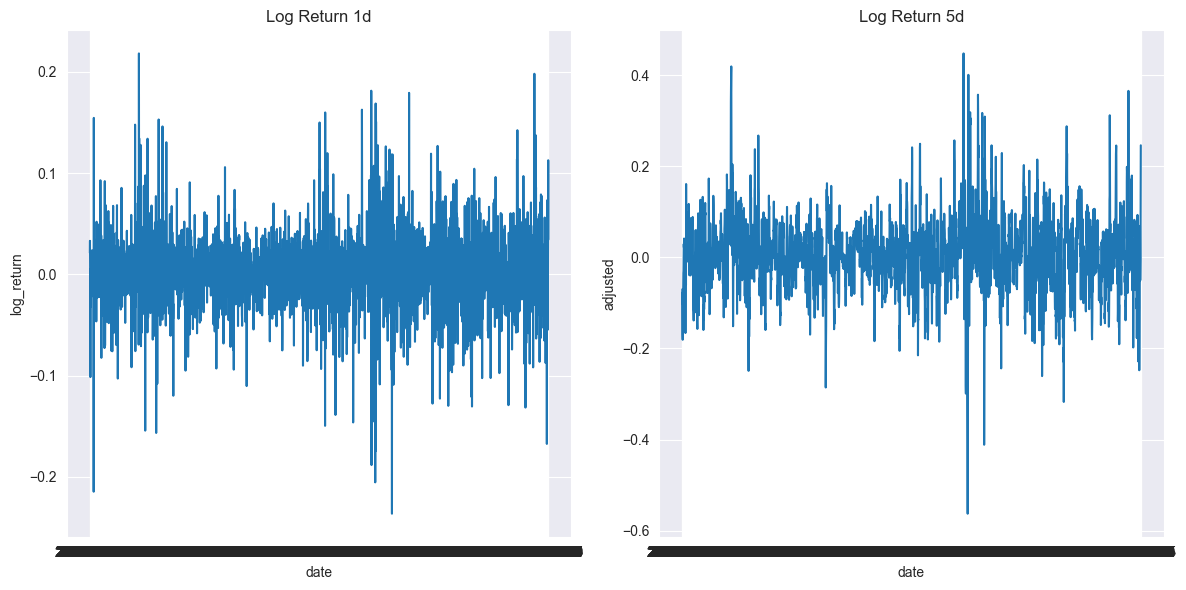

In [9]:
fig, axes = plt.subplots(1, 2, figsize=(12,6))
sns.lineplot(data=df, x='date', y='log_return', ax=axes[0])
axes[0].set_title("Log Return 1d")
sns.lineplot(data=df, x="date", y=np.log(df['adjusted'] / df['adjusted'].shift(5)), ax=axes[1])
axes[1].set_title("Log Return 5d")
plt.tight_layout()

In [ ]:
# převedeme do long formátu
df_long = df[["sentiment_negative", "sentiment_neutral", "sentiment_none", "sentiment_positive"]].melt(var_name='variable', value_name='value')

sns.countplot(data=df_long, x='variable', hue='value')
plt.title("Distribuce sentiment proměnných")

In [ ]:
fig, ax = plt.subplots(figsize=(12,6))

cols1 = ['adjusted', 'volume', 'vix', 'g_trends', 'bull_bear_spread_surv']
df_norm1 = df[cols1].apply(lambda x: (x - x.mean()) / x.std())
for col in cols1:
    ax.plot(df['date'], df_norm1[col], label=col)
ax.legend()
ax.set_title('Porovnání časových řad (skupina 1)')
ax.set_ylabel('Standardizovaná hodnota')

In [ ]:
fig, ax = plt.subplots(figsize=(12,6))

cols2 = ['adjusted', 'sma_20', 'sma_50', 'ema_20', 'basic_volatility', 'atr', 'macd', 'macd_signal', 'bb_up', 'bb_dn', 'obv', 'adx']
df_norm2 = df[cols2].apply(lambda x: (x - x.mean()) / x.std())
for col in cols2:
    ax.plot(df['date'], df_norm2[col], label=col)
ax.legend()
ax.set_title('Porovnání časových řad (skupina 2)')
ax.set_xlabel('Datum')
ax.set_ylabel('Standardizovaná hodnota')

In [ ]:
# distribuce predikovane y + v levels
fig, ax = plt.subplots(2, 1, figsize=(10, 6))

sns.histplot(df["adjusted"],  kde=True, ax=ax[0])
ax[0].set_title("Adjusted")
sns.histplot(df["log_return"], kde=True, ax=ax[1])
ax[1].set_title("Log return")

plt.tight_layout()

In [ ]:
y = df["log_return"]

# Plot pro vyvazeni trid klasifikacni y
y_clf = (y > 0.005).astype(int)
sns.countplot(x=y_clf)
plt.show()

In [ ]:
fig, ax = plt.subplots(2, 1, figsize=(10,6))
# ACF
plot_acf(df["adjusted"], ax=ax[0], lags=40)
ax[0].set_title(f"ACF pro adjusted")
# PACF
plot_pacf(df["adjusted"], ax=ax[1], lags=40)
ax[1].set_title(f"PACF pro adjusted")

plt.tight_layout()

In [ ]:
fig, ax = plt.subplots(2, 1, figsize=(10,6))
# ACF
plot_acf(y, ax=ax[0], lags=40)
ax[0].set_title(f"ACF pro log_return")
# PACF
plot_pacf(y, ax=ax[1], lags=40)
ax[1].set_title(f"PACF pro log_return")

plt.tight_layout()

In [ ]:
# Korelace features
# ukazuji pouze korelace > 0.5
mask = (df.drop(columns=["date", "adjusted"]).corr().abs() < 0.5)
sns.heatmap(df.drop(columns=["date", "adjusted"]).corr(), mask=mask, cmap="YlOrRd")


In [ ]:
sns.heatmap(df.drop(columns=["date", "adjusted"]).corr(), cmap="YlOrRd")

In [ ]:
# Korelace kazde x (lag feature) s aktualni y (log return) -> potencialni predikcni sila

# vytvoreni X a y
features = [
    'vix', 'sentiment_neutral', 'sentiment_positive', 'sentiment_negative', 'g_trends',
    'bull_bear_spread_surv', 'volume', 'sma_20',
    'sma_50', 'ema_20', 'basic_volatility', 'atr', 'rsi', 'macd',
    'macd_signal', 'bb_up', 'bb_dn', 'obv', 'stochrsi', 'adx'
]

def create_lags(lags):
    X = pd.DataFrame()

    for l in range(1, lags + 1):
        for col in features:
            X[col + f'_lag{l}'] = df[col].shift(l)

    X.dropna(inplace=True)
    return X

lags = 10

X = create_lags(lags)
features_names = X.columns

y_clf = (y > 0.005).astype(int)

# Omezeni radku dle hodnoty LAG
y, y_clf = y[lags:], y_clf[lags:]


In [ ]:
corrs = X.corrwith(y)
corrs_sorted = corrs.sort_values(ascending=False, key=abs)
print(corrs_sorted.head(20))

corrs_sorted.to_csv("python/plots_tabs/correlations_log_return.csv")

sns.barplot(corrs_sorted[:10])
plt.ylabel("Correlation with y")
plt.show()

In [ ]:
corrs = X.corrwith(y_clf)
corrs_sorted = corrs.sort_values(ascending=False, key=abs)
print(corrs_sorted.head(20))

corrs_sorted.to_csv("python/plots_tabs/correlations_log_return_clf.csv")

sns.barplot(corrs_sorted[:10])
plt.ylabel("Correlation with y_clf")
plt.show()

In [ ]:
sns.pairplot(df.drop(columns="date"), vars=df.drop(columns="date").columns[:5], height=2)

In [ ]:
sns.pairplot(df.drop(columns="date"), vars=df.drop(columns="date").columns[5:10], height=2)

In [ ]:
sns.pairplot(df.drop(columns="date"), vars=df.drop(columns="date").columns[15:21], height=2)

In [ ]:
# Feature importance na prvnim okne
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier

rfr = RandomForestRegressor(n_estimators=500, random_state=42, n_jobs=-1)
rfr.fit(X[:2630], y[:2630])

# Feature importance
rfr_importances = pd.Series(rfr.feature_importances_, index=features_names)
# jen použité feature
rfr_importances_used = rfr_importances[rfr_importances > 0].sort_values(ascending=False)



rfc = RandomForestClassifier(n_estimators=500, random_state=42, n_jobs=-1)
rfc.fit(X[:2630], y_clf[:2630])

# Feature importance
rfc_importances = pd.Series(rfc.feature_importances_, index=features_names)
# jen použité feature
rfc_importances_used = rfr_importances[rfc_importances > 0].sort_values(ascending=False)



In [ ]:
plt.figure(figsize=(25, 6))
sns.barplot(rfr_importances_used[:20])
plt.title("First Window Feature Importances By Regression")
plt.ylabel("Importance")
plt.xlabel("Feature")
plt.show()


In [ ]:
plt.figure(figsize=(25, 6))
sns.barplot(rfc_importances_used[:20])
plt.title("First Window Feature Importances")
plt.ylabel("Importance")
plt.xlabel("Feature")
plt.show()
